# Object detection / segmentation with Mask R-CNN: Mars craters

This notebook was degined to run on **Google Colab** with their dedicated GPU. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/mars-craters-detection"

/content/gdrive/My Drive/Colab Notebooks/mars-craters-detection


Install Mask R-CNN library and RAMP workflow to download the data.

In [ ]:
!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
!pip install git+https://github.com/matterport/Mask_RCNN

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [13]:
# !python download_data.py

=> File saved as data/data_train.npy
=> File saved as data/data_test.npy
=> File saved as data/labels_train.csv
=> File saved as data/labels_test.csv


## Training configuration 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import problem
import cv2
import os

import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize

from imgaug import augmenters as iaa  

Using TensorFlow backend.


In [5]:
# directory where the weights are saved
ROOT_DIR = 'logs'
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)
    

class MarsConfig(Config):
    """Configuration for training crater detection on the Mars dataset.
    Derives from the base Config class and overrides some values.
    """

    NAME = 'mars-craters'
    
    GPU_COUNT = 1
    
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 crater classes
    
    IMAGE_MIN_DIM = 256
    
    IMAGE_MAX_DIM = 256
    
    RPN_ANCHOR_SCALES = (10, 15, 20, 30, 50)
    
    TRAIN_ROIS_PER_IMAGE = 64
    
    DETECTION_MIN_CONFIDENCE = 0.95
    
    STEPS_PER_EPOCH = 100
    
    VALIDATION_STEPS = 100
    
    LEARNING_RATE = 0.001

    
config = MarsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
class MarsDataset(utils.Dataset):

    def __init__(self, X, y, size):
        super().__init__(self)
        self.size = size
        self.origin_size = X[0].shape[0]

        # add classes
        self.add_class('mars-craters', 1, 'crater')

        # add images
        images = []
        for i, image in enumerate(X):
            self.add_image('mars-craters', image_id=i, path=i, annotations=y[i], 
                           height=self.origin_size, width=self.origin_size)
            images.append(cv2.resize(image, (self.size, self.size)))
        self.X = images  

    def load_image(self, i):
        """Load the image and preprocess it."""
        # convert grayscale to RGB
        return np.stack((self.X[i],) * 3, -1)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns: 
         masks: A bool array of shape [height, width, instance count] with
             one mask per instance.
         class_ids: a 1D array of class IDs of the instance masks.        
        """
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((self.size, self.size, 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((self.size, self.size, count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, crater in enumerate(annotations):
                y, x, rad = crater
                mask_instance = mask[:, :, i].copy()
                resize_factor = self.size / self.origin_size
                cv2.circle(mask_instance, 
                           (int(x * resize_factor), int(y * resize_factor)), 
                           int(rad * resize_factor), 255, -1)
                mask[:, :, i] = mask_instance
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

## Data loading 

### Split training and validation set

In [7]:
X, y = problem.get_train_data()

train_size = 0.8

n = len(X)
n_train = np.arange(0, np.ceil(train_size * n), dtype=int)
dataset_train = MarsDataset(X[n_train], y[n_train], size=256)
dataset_train.prepare()

n_val = np.arange(np.ceil(train_size * n), n, dtype=int)
dataset_val = MarsDataset(X[n_val], y[n_val], size=256)
dataset_val.prepare()

print('Using {} images for training, {} for validation' \
      .format(len(dataset_train.image_ids), len(dataset_val.image_ids)))

Using 7200 images for training, 1800 for validation


### Inspection of the masks

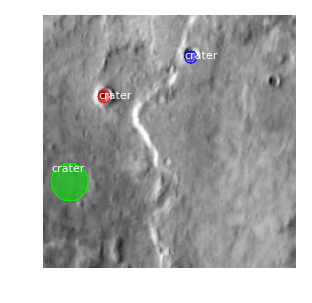

In [9]:
image_id = np.random.choice(dataset_train.image_ids, )
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

bbox = utils.extract_bboxes(mask)

visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names, 
                            figsize=(5, 5), show_bbox=False)

## Training

### Create the model and load pre-trained weights

In [10]:
# create the model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)



# load pre-trained weight of COCO
COCO_MODEL_PATH = 'mask_rcnn_coco.h5'
utils.download_trained_weights(COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.
... done downloading pretrained model!


### Data augmentation

In [ ]:
# augmentations to apply on images
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)) # small blur on 50% of the images
    ),
    iaa.Sometimes(0.3,
        iaa.Affine(
        scale=(0.8, 1.2),
        translate_percent=(-0.1, 0.1),
        rotate=(-10, 10))
    ),
    iaa.Multiply((0.8, 1.2)) # brightness
])

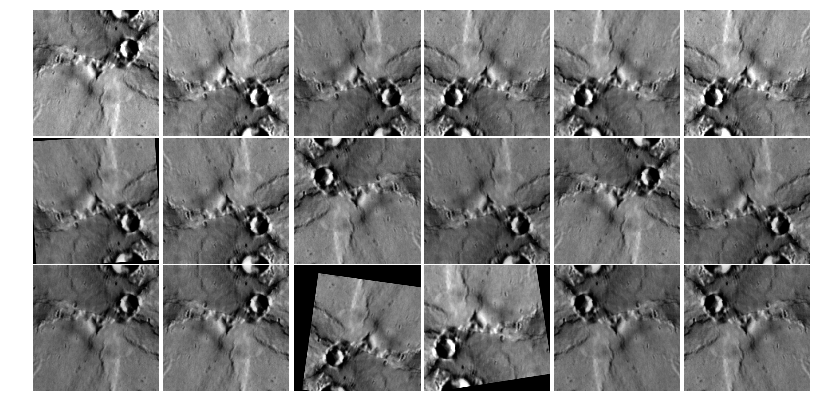

In [12]:
# visualize the data augmentation
plt.figure(figsize=(14, 7))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(augmentation.augment_image(dataset_train.load_image(0)))
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0.01)

### Fit the model

In [13]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

# tensorboard to visualize the losses
tbc = TensorBoardColab()

# train the model
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='all',
            augmentation=augmentation,
            custom_callbacks=[TensorBoardColabCallback(tbc)])

Wait for 8 seconds...
TensorBoard link:
https://5996e608.ngrok.io

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/mars-craters20190508T0734/mask_rcnn_mars-craters_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
100/100 [==============================] - 214s 2s/step - loss: 2.0935 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.9037 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.4567 - val_loss: 1.6487 - val_rpn_class_loss: 0.0219 - val_rpn_bbox_loss: 0.7272 - val_mrcnn_class_loss: 0.0308 - val_mrcnn_bbox_loss: 0.4200 - val_mrcnn_mask_loss: 0.4489
Epoch 2/10
100/100 [==============================] - 152s 2s/step - loss: 1.5833 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6987 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.4064 - val_loss: 1.5812 - val_rpn_class_loss: 0.0180 - val_rpn_bbox_loss: 0.6659 - val_mrcnn_class_loss: 0.0543 - val_mrcnn_bbox_loss: 0.4069 - val_mrcnn_mask_loss: 0.4361
Epoch 3/10
100/100 [==============================] - 154s 2s/step - loss: 1.6002 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.7089 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4107 - val_loss: 1.5654 - val_rpn_class_l

## Inference

In [14]:
class InferenceConfig(MarsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# load last trained weights
model.load_weights(model.find_last(), by_name=True)

Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 10


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 



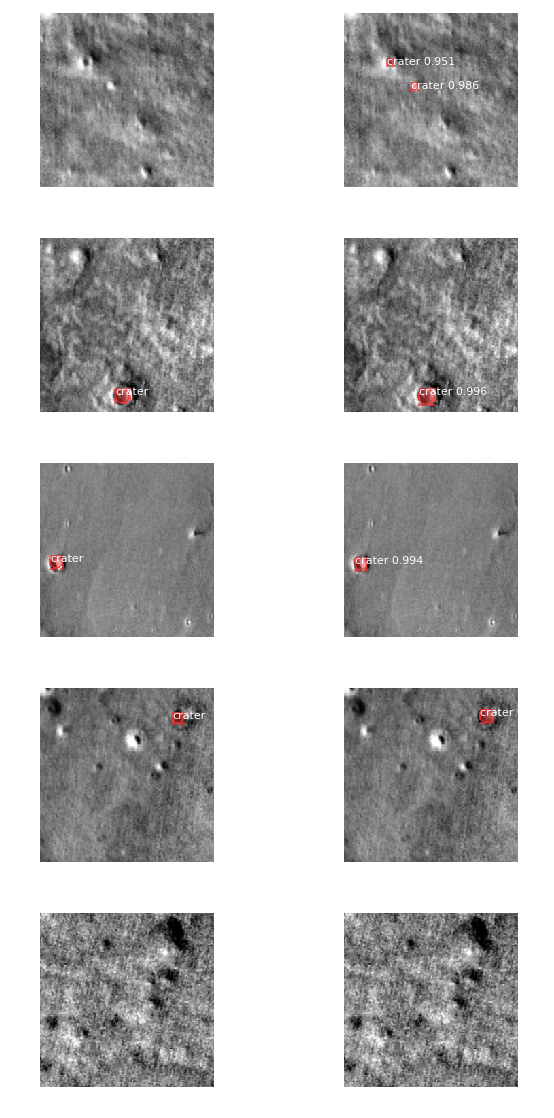

In [20]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 20))

for i in range(5):

    image_id = np.random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(5, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(5, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

### Testing set: convert the detections to circles

Here, we want to export the predictions into a list of circles for each image. The circles are represented as tuples: `(cx, cy, radius)`.

We only consider the detections where the radius is between 5 and 28px. 

In [21]:
# load the testing set
X_test, y_test = problem.get_test_data()

print(X_test.shape, y_test.shape)

(6000, 224, 224) (6000,)


In [22]:
resize_factor = 224 / 256
y_pred = []
for i in range(len(X_test)):
    if i % 1000 == 0:
        print('{} images processed'.format(i))

    # pre-process the image
    image = cv2.resize(X_test[i], (256, 256))
    image = np.stack((image,) * 3, axis=-1)

    # perform the detection
    r = model.detect([image])[0]

    circles = []
    num_instances = len(r['rois'])
    for j in range(num_instances):
        score = r['scores'][j]
        x_min, y_min, x_max, y_max = r['rois'][j]
        rad = ((((x_max - x_min) + (y_max - y_min)) / 2) / 2) * resize_factor
        cx = (x_min + (x_max - x_min) / 2) * resize_factor
        cy = (y_min + (y_max - y_min) / 2) * resize_factor
        if 5 <= rad <= 28:
            circles.append((score, cx, cy, rad))
    y_pred.append(circles)


0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed


In [23]:
# check that y_test and y_pred have the same size
print(len(y_test), len(y_pred))

6000 6000


#### Plot the circles

Ground truth in red vs. predictions in green.

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


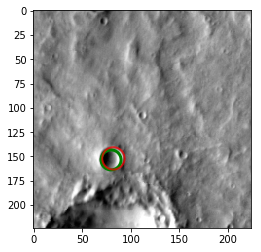

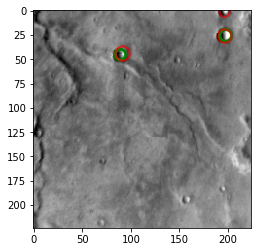

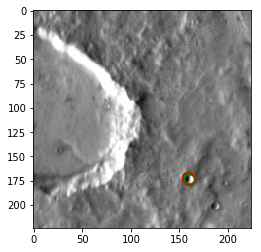

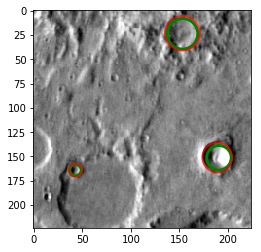

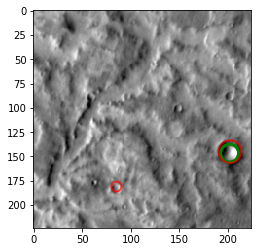

In [25]:
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

for i in range(5):
    fig, ax = plt.subplots()
    ax.grid('off')
    image = np.array(X_test[i])
    image = np.stack((image,) * 3, axis=-1)
    ax.imshow(image)
    circles = []
    for crater in y_pred[i]:
        circles.append(Circle((crater[2], crater[1]), crater[3]))

    gt = []
    for crater in y_test[i]:
        gt.append(Circle((crater[1], crater[0]), crater[2]))


    collection = PatchCollection(circles, edgecolor='green', facecolor='none', linewidth=3)
    collection2 = PatchCollection(gt, edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
    ax.add_collection(collection)
    ax.add_collection(collection2)
    fig.show()

## Evaluation

Now we can compute some metrics on the predictions. This will help us to see how our model performs. 

Here we compute:
- the Average Precision (AP)
- the Presion for different IoU thresholds
- the Recall for different IoU thresholds
- the Relative Mean absolute deviation (MAD) of the center.
- the Relative Mean absolute deviation (MAD) of the radius.

Good medium [article](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) to explain these metrics. 

In [26]:
from rampwf.score_types import DetectionAveragePrecision, DetectionPrecision
from rampwf.score_types import DetectionRecall, MADCenter, MADRadius

# The overlap between adjacent patches is 56 pixels
# The scoring region is chosen so that despite the overlap,
# no crater is scored twice, hence the boundaries of
# 28 = 56 / 2 and 196 = 224 - 56 / 2
minipatch = [28, 196, 28, 196]

score_types = [
    DetectionAveragePrecision(),
    DetectionPrecision(iou_threshold=0.0, minipatch=minipatch),
    DetectionPrecision(iou_threshold=0.5, minipatch=minipatch),
    DetectionPrecision(iou_threshold=0.9, minipatch=minipatch),
    DetectionRecall(iou_threshold=0.0, minipatch=minipatch),
    DetectionRecall(iou_threshold=0.5, minipatch=minipatch),
    DetectionRecall(iou_threshold=0.9, minipatch=minipatch),
    MADCenter(minipatch=minipatch),
    MADRadius(minipatch=minipatch)
]

for metric in score_types:
    print('{}: {:.2f}'.format(metric.name, metric(y_test, y_pred)))

average_precision: 0.58
precision(IOU=0.0): 0.77
precision(IOU=0.5): 0.77
precision(IOU=0.9): 0.50
recall(IOU=0.0): 0.68
recall(IOU=0.5): 0.67
recall(IOU=0.9): 0.44
mad_center(IOU=0.5): 0.36
mad_radius(IOU=0.5): 0.11


The model is already pretty accurate. We can probably improve the performance with a longer training. Remember that we trained only 10 epochs of 100 steps, and that the training and validation loss were still improving!

We could train during more epochs and add an `EarlyStopping` to the callbacks of the model. This would stop the training when the validation loss has stopped improving.